In [1]:
import wandb
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


def get_history(user="kealexanderwang", project="constrained-pnns", query={},
                **kwargs):
    api = wandb.Api()
    runs = api.runs(path=f"{user}/{project}", filters=query)
    dataframes = [run.history(**kwargs) for run in runs]
    if len(runs) == 0:
        return [[],[]]
    else:
        return list(zip(runs, dataframes))


def download_files(user="kealexanderwang", project="constrained-pnns",
                   query={}, save_dir=".", **kwargs):
    """
    Download the files of each run into a new directory for the run.
    Also saves the config dict of the run.
    """
    if not os.path.isdir(save_dir):
        os.mkdir(save_dir)

    api = wandb.Api()
    runs = api.runs(path=f"{user}/{project}", filters=query)
    for run in runs:
        name = run.name
        config = run.config

        run_dir = os.path.join(save_dir, name)
        if not os.path.isdir(run_dir):
            os.mkdir(run_dir)

        with open(os.path.join(run_dir, "config.pkl"), "wb") as h:
            pickle.dump(config, h)

        files = run.files()
        for file in files:
            file.download(root=run_dir)
    return

In [2]:
from pytorch_lightning import Trainer
from pl_trainer import DynamicsModel, SaveTestLogCallback
import os

def load_model_from_run(run, save_dir="/tmp"):
    name = run.display_name
    ckpt_save_path = os.path.join(save_dir, name)
    if not os.path.exists(ckpt_save_path):
        os.makedirs(ckpt_save_path)
     
    ckpts = sorted([f for f in run.files() if "checkpoints" in f.name])
    if len(ckpts) == 0:
        raise RuntimeError(f"Run {name} has no checkpoints!")
    # pick latest checkpoint if available
    last_ckpt = ckpts[-1]
    last_ckpt.download(replace=True, root=ckpt_save_path)
        
    ckpt_path = os.path.join(ckpt_save_path, last_ckpt.name)
    # Uncommet if you need the trainer
    pl_trainer = Trainer(resume_from_checkpoint=ckpt_path,logger=False)
    pl_model = DynamicsModel.load_from_checkpoint(ckpt_path)
    
    import pprint 
    pp = pprint.PrettyPrinter(indent=4)
    print("--------------------------------")
    print("Model Hyperparameters:")
    pp.pprint(vars(pl_model.hparams))
    print("--------------------------------")
    return pl_trainer, pl_model

def load_file_from_run(run, filename, save_dir="/tmp", replace=False):
    name = run.display_name
    save_path = os.path.join(save_dir, name)
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    for f in run.files():
        if filename in f.name:
            file_path = os.path.join(save_path, f.name)
            if not os.path.exists(file_path):
                f.download(replace=replace, root=save_path)
            else:
                print("File already exists")
            return file_path
    raise ValueError("File not found in run!")

In [3]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [4]:
def norm_sq(model, p="fro"):
    return sum(param.norm(p=p)**2 for param in model.parameters())

In [5]:
import torch
import time
import numpy as np
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable

from gpytorch.utils.lanczos import lanczos_tridiag, lanczos_tridiag_to_diag

def unflatten_like(vector, likeTensorList):
    # Takes a flat torch.tensor and unflattens it to a list of torch.tensors
    #    shaped like likeTensorList
    outList = []
    i = 0
    for tensor in likeTensorList:
        n = tensor.numel()
        outList.append(vector[:, i : i + n].view(tensor.shape))
        i += n
    return outList

################################################################################
#                              Supporting Functions
################################################################################
def gradtensor_to_tensor(net, include_bn=False):
    """
        convert the grad tensors to a list
    """
    #filter = lambda p: include_bn or len(p.data.size()) > 1
    return flatten([p.grad.data if p.grad is not None else torch.zeros_like(p)
                    for p in net.parameters()])


################################################################################
#                  For computing Hessian-vector products
################################################################################
def eval_hess_vec_prod(vec, net, criterion, inputs=None, targets=None,
                       dataloader=None,
                       use_cuda=False):
    """
    Evaluate product of the Hessian of the loss function with a direction vector "vec".
    The product result is saved in the grad of net.
    Args:
        vec: a list of tensor with the same dimensions as "params".
        params: the parameter list of the net (ignoring biases and BN parameters).
        net: model with trained parameters.
        criterion: loss function.
        dataloader: dataloader for the dataset.
        use_cuda: use GPU.
    """

    if use_cuda:
        net.cuda()
        vec = [v.cuda() for v in vec]

    net.zero_grad()  # clears grad for every parameter in the net
    if dataloader is None:
        inputs, targets = Variable(inputs), Variable(targets)
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()

        # outputs = net(inputs)
        loss = criterion(net(inputs), targets)
        grad_f = torch.autograd.grad(loss, inputs=net.parameters(), create_graph=True)

        # Compute inner product of gradient with the direction vector
        # prod = Variable(torch.zeros(1)).type(type(grad_f[0].data))
        prod = torch.zeros(1, dtype=grad_f[0].dtype, device=grad_f[0].device)
        for (g, v) in zip(grad_f, vec):
            print(g.shape, v.shape)
            prod = prod + (g * v).sum()

        # Compute the Hessian-vector product, H*v
        # prod.backward() computes dprod/dparams for every parameter in params and
        # accumulate the gradients into the params.grad attributes
        prod.backward()
    else:
        for batch_idx, (inputs, targets) in enumerate(dataloader):
            #inputs, targets = Variable(inputs), Variable(targets)
            if use_cuda:
                targets = targets.cuda()
                if isinstance(inputs, list):
                    inputs = [i.cuda() for i in inputs]
                else:
                    inputs = inputs.cuda()

            loss = criterion(net(inputs), targets)
            
            grad_f = torch.autograd.grad(loss, inputs=net.parameters(), create_graph=True,
                                         allow_unused=True)
            # Compute inner product of gradient with the direction vector
            prod = 0.
            for (g, v) in zip(grad_f, vec):
                if g is not None:
                    prod = prod + (g * v).sum()

            # Compute the Hessian-vector product, H*v
            # prod.backward() computes dprod/dparams for every parameter in params and
            # accumulate the gradients into the params.grad attributes
            prod.backward()

def flatten(lst):
    tmp = [i.contiguous().view(-1, 1) for i in lst]
    return torch.cat(tmp).view(-1)

#############################
# Return Hessian of a model #
#############################

def get_hessian(train_x, train_y, loss, model, use_cuda=False):
    n_par = sum(torch.numel(p) for p in model.parameters())
    hessian = torch.zeros(n_par, n_par)
    if use_cuda:
        model = model.cuda()
    else:
        model = model.cpu()

    for pp in range(n_par):
        base_vec = torch.zeros(n_par).unsqueeze(0)
        if use_cuda:
            base_vec = base_vec.cuda()
            model = model.cuda()

        base_vec[0, pp] = 1.

        base_vec = unflatten_like(base_vec, model.parameters())
        eval_hess_vec_prod(base_vec,
                                # model.parameters(),
                                net=model,
                                criterion=loss,
                                inputs=train_x, targets=train_y)
        if pp == 0:
            output = gradtensor_to_tensor(model, include_bn=True)
            hessian = torch.zeros(output.nelement(), output.nelement())
            hessian[:, pp] = output

        hessian[:, pp] = gradtensor_to_tensor(model, include_bn=True)

    return hessian


def get_hessian_eigs(loss, model, mask=None,
                     use_cuda=False, n_eigs=100, train_x=None, train_y=None,
                     loader=None, evals=False):
    if train_x is not None:
        if use_cuda:
            train_x = train_x.cuda()
            train_y = train_y.cuda()

    total_pars = sum(m.numel() for m in model.parameters())
    if n_eigs != -1:
        if mask is not None:
            numpars = int(mask.sum().item())
        else:
            numpars = total_pars
            p = next(iter(model.parameters()))
            mask = torch.ones(total_pars, dtype=p.dtype, device=p.device)

#         def hvp(rhs):
#             padded_rhs = unflatten_like(rhs.t(), model.parameters())
#             eval_hess_vec_prod(padded_rhs, net=model,
#                                criterion=loss, inputs=train_x,
#                                targets=train_y, dataloader=loader, use_cuda=use_cuda)
#             full_hvp = gradtensor_to_tensor(model, include_bn=True)
#             return full_hvp
        
        def hvp(vec):
            vec = unflatten_like(vec.t(), model.parameters())
            eval_hess_vec_prod(vec, model, criterion=loss,
                               dataloader=loader, use_cuda=use_cuda,
                               inputs=train_x, targets=train_y)
            out = gradtensor_to_tensor(model)
            if loader is not None:
                out = out / len(loader)
            return out.unsqueeze(1)
        
        if train_x is None:
            data = next(iter(loader))[0]
            if use_cuda:
                if isinstance(data, list):
                    data = [d.cuda() for d in data]
                    dtype = data[0].dtype
                    device = data[0].device
                else:
                    data = data.cuda()
                    dtype = data.dtype
                    device = data.device
            else:
                if isinstance(data, list):
                    dtype = data[0].dtype
                    device = data[0].device
                else:
                    dtype = data.dtype
                    device = data.device
        else:
            dtype, device = train_x.dtype, train_x.device

        qmat, tmat = lanczos_tridiag(hvp, n_eigs, dtype=dtype,
                                  device=device, matrix_shape=(numpars,
                                  numpars))
        eigs, t_evals = lanczos_tridiag_to_diag(tmat)
        if evals:
            return eigs, qmat @ t_evals
        return eigs
    else:
        # form and extract sub hessian
        hessian = get_hessian(train_x, train_y, loss, model, use_cuda=use_cuda)

        keepers = np.array(np.where(mask.cpu() == 1))[0]
        sub_hess = hessian[np.ix_(keepers, keepers)]
        e_val, _ = np.linalg.eig(sub_hess.cpu().detach())
        return e_val.real

In [6]:
class WrappedModel(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        
    def forward(self, batch_x):
        (z0, ts) = batch_x
        ts = ts[0] - ts[0, 0]
        pred_zs = self.model.rollout(z0, ts, tol=self.model.hparams.tol, method="rk4")
        return pred_zs
    
    def loss(self, pred_zs, zts):
        return self.model.trajectory_mae(pred_zs, zts)

In [7]:
def eff_dof(evals, z=1e-2, axis=-1):
    evals = np.copy(evals)
    i = np.nonzero(evals == 1.) # these are junk
    evals[i] = 0
    return np.sum(evals / (evals + z), axis=axis)

In [8]:
def stable_rank(evals, axis=-1):
    evals = np.copy(evals)
    i = np.nonzero(evals == 1.) # these are junk
    evals[i] = 0
    return np.sum(evals, axis=axis) / np.max(evals, axis=axis)

In [9]:
def spectral_norm(evals, axis=-1):
    evals = np.copy(evals)
    i = np.nonzero(evals == 1.) # these are junk
    evals[i] = 0
    return np.max(evals, axis=axis)

In [10]:
def frobenius_norm(evals, axis=-1):
    evals = np.copy(evals)
    i = np.nonzero(evals == 1.) # these are junk
    evals[i] = 0
    return np.sqrt(np.sum(evals, axis=axis))

In [11]:
import torch
# See https://docs.wandb.com/library/reference/wandb_api for how to write queries

values = []
for network_class in ["CHNN", "HNN"]:
    for n in [1, 2, 3, 4, 5]:
        query = {"$and": [
                      {"tags": "submission"},
                      {"tags": "complexity"},
                      {"state": "finished"},
                      {"config.body_args": [n]},
                      {"config.body_class": "ChainPendulum"},
                      {"config.network_class": network_class},
                     ]}

        try:
            runs, histories = zip(*get_history(query=query))
            print(f"Found {len(runs)} runs for {network_class} on {n} pendulums")
        except ValueError: #some runs may not be done yet
             continue
        
        
        for batch, run in enumerate(runs):
            trainer, model = load_model_from_run(run)

            with torch.no_grad():
                model_norm_sq = norm_sq(model.model).item()
                model_num_params = count_parameters(model.model)

            model_wrapped = WrappedModel(model)

            eig_val = get_hessian_eigs(loss=model_wrapped.loss, model=model_wrapped, loader=model.train_dataloader(),
                                    use_cuda=True, n_eigs=1000)

            eig_val = eig_val.detach().cpu().numpy()
                
            fields = ["num_pendulums", "network", "batch", "norm_sq", "num_params", "eig_val"]
            for ev in eig_val:
                values.append([n, network_class, batch, model_norm_sq, model_num_params, ev])

Found 3 runs for CHNN on 1 pendulums


INFO:lightning:GPU available: True, used: False
/home/alex/miniconda3/envs/ham37v2/lib/python3.7/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'pl_trainer.DynamicsModel' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


CH ignores angular_dims
CH currently assumes potential energy depends only on q
CH currently assumes time independent Hamiltonian
CH assumes positions q are in Cartesian coordinates
--------------------------------
Model Hyperparameters:
{   'angular_dims': range(0, 1),
    'batch_size': 200,
    'body_args': [1],
    'body_class': 'ChainPendulum',
    'callbacks': [   <pytorch_lightning.callbacks.lr_logger.LearningRateLogger object at 0x7f115a8bafd0>,
    'check_val_every_n_epoch': 100,
    'chunk_len': 5,
    'ckpt_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn1mrlr/CHNN/wandb/run-20200601_025425-189eghsq/constrained-pnns/version_189eghsq/checkpoints',
    'dataset_class': 'RigidBodyDataset',
    'debug': False,
    'dof_ndim': 2,
    'dt': 0.03,
    'euclidean': True,
    'exp_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn1mrlr/CHNN',
    'fast_dev_run': False,
    'gpus': 1,
    'hidden_size': 256,
    'integration_time': 3,
    'lo

INFO:lightning:GPU available: True, used: False


CH ignores angular_dims
CH currently assumes potential energy depends only on q
CH currently assumes time independent Hamiltonian
CH assumes positions q are in Cartesian coordinates
--------------------------------
Model Hyperparameters:
{   'angular_dims': range(0, 1),
    'batch_size': 200,
    'body_args': [1],
    'body_class': 'ChainPendulum',
    'callbacks': [   <pytorch_lightning.callbacks.lr_logger.LearningRateLogger object at 0x7f1152d9d490>,
    'check_val_every_n_epoch': 100,
    'chunk_len': 5,
    'ckpt_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn1mrlr/CHNN/wandb/run-20200601_020257-1172pp65/constrained-pnns/version_1172pp65/checkpoints',
    'dataset_class': 'RigidBodyDataset',
    'debug': False,
    'dof_ndim': 2,
    'dt': 0.03,
    'euclidean': True,
    'exp_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn1mrlr/CHNN',
    'fast_dev_run': False,
    'gpus': 1,
    'hidden_size': 256,
    'integration_time': 3,
    'lo

INFO:lightning:GPU available: True, used: False


CH ignores angular_dims
CH currently assumes potential energy depends only on q
CH currently assumes time independent Hamiltonian
CH assumes positions q are in Cartesian coordinates
--------------------------------
Model Hyperparameters:
{   'angular_dims': range(0, 1),
    'batch_size': 200,
    'body_args': [1],
    'body_class': 'ChainPendulum',
    'callbacks': [   <pytorch_lightning.callbacks.lr_logger.LearningRateLogger object at 0x7f115a7f1d90>,
    'check_val_every_n_epoch': 100,
    'chunk_len': 5,
    'ckpt_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn1mrlr/CHNN/wandb/run-20200601_011145-2dj1etxt/constrained-pnns/version_2dj1etxt/checkpoints',
    'dataset_class': 'RigidBodyDataset',
    'debug': False,
    'dof_ndim': 2,
    'dt': 0.03,
    'euclidean': True,
    'exp_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn1mrlr/CHNN',
    'fast_dev_run': False,
    'gpus': 1,
    'hidden_size': 256,
    'integration_time': 3,
    'lo

INFO:lightning:GPU available: True, used: False


CH ignores angular_dims
CH currently assumes potential energy depends only on q
CH currently assumes time independent Hamiltonian
CH assumes positions q are in Cartesian coordinates
--------------------------------
Model Hyperparameters:
{   'angular_dims': range(0, 2),
    'batch_size': 200,
    'body_args': [2],
    'body_class': 'ChainPendulum',
    'callbacks': [   <pytorch_lightning.callbacks.lr_logger.LearningRateLogger object at 0x7f115aa0f8d0>,
    'check_val_every_n_epoch': 100,
    'chunk_len': 5,
    'ckpt_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn2mrlr/CHNN/wandb/run-20200601_054211-19719rdr/constrained-pnns/version_19719rdr/checkpoints',
    'dataset_class': 'RigidBodyDataset',
    'debug': False,
    'dof_ndim': 2,
    'dt': 0.03,
    'euclidean': True,
    'exp_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn2mrlr/CHNN',
    'fast_dev_run': False,
    'gpus': 1,
    'hidden_size': 256,
    'integration_time': 3,
    'lo

INFO:lightning:GPU available: True, used: False


CH ignores angular_dims
CH currently assumes potential energy depends only on q
CH currently assumes time independent Hamiltonian
CH assumes positions q are in Cartesian coordinates
--------------------------------
Model Hyperparameters:
{   'angular_dims': range(0, 2),
    'batch_size': 200,
    'body_args': [2],
    'body_class': 'ChainPendulum',
    'callbacks': [   <pytorch_lightning.callbacks.lr_logger.LearningRateLogger object at 0x7f115190af10>,
    'check_val_every_n_epoch': 100,
    'chunk_len': 5,
    'ckpt_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn2mrlr/CHNN/wandb/run-20200601_044446-gg1ib0p5/constrained-pnns/version_gg1ib0p5/checkpoints',
    'dataset_class': 'RigidBodyDataset',
    'debug': False,
    'dof_ndim': 2,
    'dt': 0.03,
    'euclidean': True,
    'exp_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn2mrlr/CHNN',
    'fast_dev_run': False,
    'gpus': 1,
    'hidden_size': 256,
    'integration_time': 3,
    'lo

INFO:lightning:GPU available: True, used: False


CH ignores angular_dims
CH currently assumes potential energy depends only on q
CH currently assumes time independent Hamiltonian
CH assumes positions q are in Cartesian coordinates
--------------------------------
Model Hyperparameters:
{   'angular_dims': range(0, 2),
    'batch_size': 200,
    'body_args': [2],
    'body_class': 'ChainPendulum',
    'callbacks': [   <pytorch_lightning.callbacks.lr_logger.LearningRateLogger object at 0x7f115aa2ec10>,
    'check_val_every_n_epoch': 100,
    'chunk_len': 5,
    'ckpt_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn2mrlr/CHNN/wandb/run-20200601_034701-25qpuvyq/constrained-pnns/version_25qpuvyq/checkpoints',
    'dataset_class': 'RigidBodyDataset',
    'debug': False,
    'dof_ndim': 2,
    'dt': 0.03,
    'euclidean': True,
    'exp_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn2mrlr/CHNN',
    'fast_dev_run': False,
    'gpus': 1,
    'hidden_size': 256,
    'integration_time': 3,
    'lo

INFO:lightning:GPU available: True, used: False


CH ignores angular_dims
CH currently assumes potential energy depends only on q
CH currently assumes time independent Hamiltonian
CH assumes positions q are in Cartesian coordinates
--------------------------------
Model Hyperparameters:
{   'angular_dims': range(0, 3),
    'batch_size': 200,
    'body_args': [3],
    'body_class': 'ChainPendulum',
    'callbacks': [   <pytorch_lightning.callbacks.lr_logger.LearningRateLogger object at 0x7f115a8bae10>,
    'check_val_every_n_epoch': 100,
    'chunk_len': 5,
    'ckpt_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn3mrlr/CHNN/wandb/run-20200601_084745-tqdrllpr/constrained-pnns/version_tqdrllpr/checkpoints',
    'dataset_class': 'RigidBodyDataset',
    'debug': False,
    'dof_ndim': 2,
    'dt': 0.03,
    'euclidean': True,
    'exp_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn3mrlr/CHNN',
    'fast_dev_run': False,
    'gpus': 1,
    'hidden_size': 256,
    'integration_time': 3,
    'lo

INFO:lightning:GPU available: True, used: False


CH ignores angular_dims
CH currently assumes potential energy depends only on q
CH currently assumes time independent Hamiltonian
CH assumes positions q are in Cartesian coordinates
--------------------------------
Model Hyperparameters:
{   'angular_dims': range(0, 3),
    'batch_size': 200,
    'body_args': [3],
    'body_class': 'ChainPendulum',
    'callbacks': [   <pytorch_lightning.callbacks.lr_logger.LearningRateLogger object at 0x7f115a7f1410>,
    'check_val_every_n_epoch': 100,
    'chunk_len': 5,
    'ckpt_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn3mrlr/CHNN/wandb/run-20200601_074356-x4ywxjji/constrained-pnns/version_x4ywxjji/checkpoints',
    'dataset_class': 'RigidBodyDataset',
    'debug': False,
    'dof_ndim': 2,
    'dt': 0.03,
    'euclidean': True,
    'exp_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn3mrlr/CHNN',
    'fast_dev_run': False,
    'gpus': 1,
    'hidden_size': 256,
    'integration_time': 3,
    'lo

INFO:lightning:GPU available: True, used: False


CH ignores angular_dims
CH currently assumes potential energy depends only on q
CH currently assumes time independent Hamiltonian
CH assumes positions q are in Cartesian coordinates
--------------------------------
Model Hyperparameters:
{   'angular_dims': range(0, 3),
    'batch_size': 200,
    'body_args': [3],
    'body_class': 'ChainPendulum',
    'callbacks': [   <pytorch_lightning.callbacks.lr_logger.LearningRateLogger object at 0x7f11dc34b610>,
    'check_val_every_n_epoch': 100,
    'chunk_len': 5,
    'ckpt_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn3mrlr/CHNN/wandb/run-20200601_064010-1vn8ada2/constrained-pnns/version_1vn8ada2/checkpoints',
    'dataset_class': 'RigidBodyDataset',
    'debug': False,
    'dof_ndim': 2,
    'dt': 0.03,
    'euclidean': True,
    'exp_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn3mrlr/CHNN',
    'fast_dev_run': False,
    'gpus': 1,
    'hidden_size': 256,
    'integration_time': 3,
    'lo

INFO:lightning:GPU available: True, used: False


CH ignores angular_dims
CH currently assumes potential energy depends only on q
CH currently assumes time independent Hamiltonian
CH assumes positions q are in Cartesian coordinates
--------------------------------
Model Hyperparameters:
{   'angular_dims': range(0, 4),
    'batch_size': 200,
    'body_args': [4],
    'body_class': 'ChainPendulum',
    'callbacks': [   <pytorch_lightning.callbacks.lr_logger.LearningRateLogger object at 0x7f11518b3650>,
    'check_val_every_n_epoch': 100,
    'chunk_len': 5,
    'ckpt_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn4mrlr/CHNN/wandb/run-20200601_182721-1mml9wuv/constrained-pnns/version_1mml9wuv/checkpoints',
    'dataset_class': 'RigidBodyDataset',
    'debug': False,
    'dof_ndim': 2,
    'dt': 0.03,
    'euclidean': True,
    'exp_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn4mrlr/CHNN',
    'fast_dev_run': False,
    'gpus': 1,
    'hidden_size': 256,
    'integration_time': 3,
    'lo

INFO:lightning:GPU available: True, used: False


CH ignores angular_dims
CH currently assumes potential energy depends only on q
CH currently assumes time independent Hamiltonian
CH assumes positions q are in Cartesian coordinates
--------------------------------
Model Hyperparameters:
{   'angular_dims': range(0, 4),
    'batch_size': 200,
    'body_args': [4],
    'body_class': 'ChainPendulum',
    'callbacks': [   <pytorch_lightning.callbacks.lr_logger.LearningRateLogger object at 0x7f11517c6150>,
    'check_val_every_n_epoch': 100,
    'chunk_len': 5,
    'ckpt_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn4mrlr/CHNN/wandb/run-20200601_171715-1civ639v/constrained-pnns/version_1civ639v/checkpoints',
    'dataset_class': 'RigidBodyDataset',
    'debug': False,
    'dof_ndim': 2,
    'dt': 0.03,
    'euclidean': True,
    'exp_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn4mrlr/CHNN',
    'fast_dev_run': False,
    'gpus': 1,
    'hidden_size': 256,
    'integration_time': 3,
    'lo

INFO:lightning:GPU available: True, used: False


CH ignores angular_dims
CH currently assumes potential energy depends only on q
CH currently assumes time independent Hamiltonian
CH assumes positions q are in Cartesian coordinates
--------------------------------
Model Hyperparameters:
{   'angular_dims': range(0, 4),
    'batch_size': 200,
    'body_args': [4],
    'body_class': 'ChainPendulum',
    'callbacks': [   <pytorch_lightning.callbacks.lr_logger.LearningRateLogger object at 0x7f11518b3150>,
    'check_val_every_n_epoch': 100,
    'chunk_len': 5,
    'ckpt_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn4mrlr/CHNN/wandb/run-20200601_160637-3u4kmj80/constrained-pnns/version_3u4kmj80/checkpoints',
    'dataset_class': 'RigidBodyDataset',
    'debug': False,
    'dof_ndim': 2,
    'dt': 0.03,
    'euclidean': True,
    'exp_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn4mrlr/CHNN',
    'fast_dev_run': False,
    'gpus': 1,
    'hidden_size': 256,
    'integration_time': 3,
    'lo

INFO:lightning:GPU available: True, used: False


CH ignores angular_dims
CH currently assumes potential energy depends only on q
CH currently assumes time independent Hamiltonian
CH assumes positions q are in Cartesian coordinates
--------------------------------
Model Hyperparameters:
{   'angular_dims': range(0, 5),
    'batch_size': 200,
    'body_args': [5],
    'body_class': 'ChainPendulum',
    'callbacks': [   <pytorch_lightning.callbacks.lr_logger.LearningRateLogger object at 0x7f1151801110>,
    'check_val_every_n_epoch': 100,
    'chunk_len': 5,
    'ckpt_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn5mrlr/CHNN/wandb/run-20200601_220333-1oqsrmje/constrained-pnns/version_1oqsrmje/checkpoints',
    'dataset_class': 'RigidBodyDataset',
    'debug': False,
    'dof_ndim': 2,
    'dt': 0.03,
    'euclidean': True,
    'exp_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn5mrlr/CHNN',
    'fast_dev_run': False,
    'gpus': 1,
    'hidden_size': 256,
    'integration_time': 3,
    'lo

INFO:lightning:GPU available: True, used: False


CH ignores angular_dims
CH currently assumes potential energy depends only on q
CH currently assumes time independent Hamiltonian
CH assumes positions q are in Cartesian coordinates
--------------------------------
Model Hyperparameters:
{   'angular_dims': range(0, 5),
    'batch_size': 200,
    'body_args': [5],
    'body_class': 'ChainPendulum',
    'callbacks': [   <pytorch_lightning.callbacks.lr_logger.LearningRateLogger object at 0x7f1151846050>,
    'check_val_every_n_epoch': 100,
    'chunk_len': 5,
    'ckpt_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn5mrlr/CHNN/wandb/run-20200601_205024-1ytpphaf/constrained-pnns/version_1ytpphaf/checkpoints',
    'dataset_class': 'RigidBodyDataset',
    'debug': False,
    'dof_ndim': 2,
    'dt': 0.03,
    'euclidean': True,
    'exp_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn5mrlr/CHNN',
    'fast_dev_run': False,
    'gpus': 1,
    'hidden_size': 256,
    'integration_time': 3,
    'lo

INFO:lightning:GPU available: True, used: False


CH ignores angular_dims
CH currently assumes potential energy depends only on q
CH currently assumes time independent Hamiltonian
CH assumes positions q are in Cartesian coordinates
--------------------------------
Model Hyperparameters:
{   'angular_dims': range(0, 5),
    'batch_size': 200,
    'body_args': [5],
    'body_class': 'ChainPendulum',
    'callbacks': [   <pytorch_lightning.callbacks.lr_logger.LearningRateLogger object at 0x7f115180c310>,
    'check_val_every_n_epoch': 100,
    'chunk_len': 5,
    'ckpt_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn5mrlr/CHNN/wandb/run-20200601_193349-emgkr8ob/constrained-pnns/version_emgkr8ob/checkpoints',
    'dataset_class': 'RigidBodyDataset',
    'debug': False,
    'dof_ndim': 2,
    'dt': 0.03,
    'euclidean': True,
    'exp_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn5mrlr/CHNN',
    'fast_dev_run': False,
    'gpus': 1,
    'hidden_size': 256,
    'integration_time': 3,
    'lo

INFO:lightning:GPU available: True, used: False
/home/alex/miniconda3/envs/ham37v2/lib/python3.7/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'biases.models.hnn.HNN' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


tensor(8.4186e-07, dtype=torch.float64)
tensor(7.9690e-07, dtype=torch.float64)
tensor(3.0203e-06, dtype=torch.float64)
HNN currently assumes potential energy depends only on q
HNN currently assumes time independent Hamiltonian
--------------------------------
Model Hyperparameters:
{   'angular_dims': range(0, 1),
    'batch_size': 200,
    'body_args': [1],
    'body_class': 'ChainPendulum',
    'callbacks': [   <pytorch_lightning.callbacks.lr_logger.LearningRateLogger object at 0x7f115177be50>,
    'check_val_every_n_epoch': 100,
    'chunk_len': 5,
    'ckpt_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn1mrlr/HNN/wandb/run-20200601_031609-i0a379q6/constrained-pnns/version_i0a379q6/checkpoints',
    'dataset_class': 'RigidBodyDataset',
    'debug': False,
    'dof_ndim': 1,
    'dt': 0.03,
    'euclidean': False,
    'exp_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn1mrlr/HNN',
    'fast_dev_run': False,
    'gpus': 1,
    'hidden_s

INFO:lightning:GPU available: True, used: False


tensor(2.6206e-06, dtype=torch.float64)
tensor(7.9690e-07, dtype=torch.float64)
tensor(3.0203e-06, dtype=torch.float64)
HNN currently assumes potential energy depends only on q
HNN currently assumes time independent Hamiltonian
--------------------------------
Model Hyperparameters:
{   'angular_dims': range(0, 1),
    'batch_size': 200,
    'body_args': [1],
    'body_class': 'ChainPendulum',
    'callbacks': [   <pytorch_lightning.callbacks.lr_logger.LearningRateLogger object at 0x7f1151859dd0>,
    'check_val_every_n_epoch': 100,
    'chunk_len': 5,
    'ckpt_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn1mrlr/HNN/wandb/run-20200601_022515-32ml70s2/constrained-pnns/version_32ml70s2/checkpoints',
    'dataset_class': 'RigidBodyDataset',
    'debug': False,
    'dof_ndim': 1,
    'dt': 0.03,
    'euclidean': False,
    'exp_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn1mrlr/HNN',
    'fast_dev_run': False,
    'gpus': 1,
    'hidden_s

INFO:lightning:GPU available: True, used: False


tensor(2.6206e-06, dtype=torch.float64)
tensor(7.9690e-07, dtype=torch.float64)
tensor(3.0203e-06, dtype=torch.float64)
HNN currently assumes potential energy depends only on q
HNN currently assumes time independent Hamiltonian
--------------------------------
Model Hyperparameters:
{   'angular_dims': range(0, 1),
    'batch_size': 200,
    'body_args': [1],
    'body_class': 'ChainPendulum',
    'callbacks': [   <pytorch_lightning.callbacks.lr_logger.LearningRateLogger object at 0x7f1150677110>,
    'check_val_every_n_epoch': 100,
    'chunk_len': 5,
    'ckpt_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn1mrlr/HNN/wandb/run-20200601_013351-uw2o05el/constrained-pnns/version_uw2o05el/checkpoints',
    'dataset_class': 'RigidBodyDataset',
    'debug': False,
    'dof_ndim': 1,
    'dt': 0.03,
    'euclidean': False,
    'exp_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn1mrlr/HNN',
    'fast_dev_run': False,
    'gpus': 1,
    'hidden_s

INFO:lightning:GPU available: True, used: False


tensor(5.6250e-06, dtype=torch.float64)
tensor(5.0418e-06, dtype=torch.float64)
tensor(2.6932e-05, dtype=torch.float64)
HNN currently assumes potential energy depends only on q
HNN currently assumes time independent Hamiltonian
--------------------------------
Model Hyperparameters:
{   'angular_dims': range(0, 2),
    'batch_size': 200,
    'body_args': [2],
    'body_class': 'ChainPendulum',
    'callbacks': [   <pytorch_lightning.callbacks.lr_logger.LearningRateLogger object at 0x7f1151746050>,
    'check_val_every_n_epoch': 100,
    'chunk_len': 5,
    'ckpt_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn2mrlr/HNN/wandb/run-20200601_060937-mqgp1dmt/constrained-pnns/version_mqgp1dmt/checkpoints',
    'dataset_class': 'RigidBodyDataset',
    'debug': False,
    'dof_ndim': 2,
    'dt': 0.03,
    'euclidean': False,
    'exp_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn2mrlr/HNN',
    'fast_dev_run': False,
    'gpus': 1,
    'hidden_s

INFO:lightning:GPU available: True, used: False


tensor(8.7625e-06, dtype=torch.float64)
tensor(5.0418e-06, dtype=torch.float64)
tensor(2.6932e-05, dtype=torch.float64)
HNN currently assumes potential energy depends only on q
HNN currently assumes time independent Hamiltonian
--------------------------------
Model Hyperparameters:
{   'angular_dims': range(0, 2),
    'batch_size': 200,
    'body_args': [2],
    'body_class': 'ChainPendulum',
    'callbacks': [   <pytorch_lightning.callbacks.lr_logger.LearningRateLogger object at 0x7f115a873c10>,
    'check_val_every_n_epoch': 100,
    'chunk_len': 5,
    'ckpt_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn2mrlr/HNN/wandb/run-20200601_051205-3o37794k/constrained-pnns/version_3o37794k/checkpoints',
    'dataset_class': 'RigidBodyDataset',
    'debug': False,
    'dof_ndim': 2,
    'dt': 0.03,
    'euclidean': False,
    'exp_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn2mrlr/HNN',
    'fast_dev_run': False,
    'gpus': 1,
    'hidden_s

INFO:lightning:GPU available: True, used: False


tensor(8.7625e-06, dtype=torch.float64)
tensor(5.0418e-06, dtype=torch.float64)
tensor(2.6932e-05, dtype=torch.float64)
HNN currently assumes potential energy depends only on q
HNN currently assumes time independent Hamiltonian
--------------------------------
Model Hyperparameters:
{   'angular_dims': range(0, 2),
    'batch_size': 200,
    'body_args': [2],
    'body_class': 'ChainPendulum',
    'callbacks': [   <pytorch_lightning.callbacks.lr_logger.LearningRateLogger object at 0x7f115a873810>,
    'check_val_every_n_epoch': 100,
    'chunk_len': 5,
    'ckpt_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn2mrlr/HNN/wandb/run-20200601_041413-1dfwd5kh/constrained-pnns/version_1dfwd5kh/checkpoints',
    'dataset_class': 'RigidBodyDataset',
    'debug': False,
    'dof_ndim': 2,
    'dt': 0.03,
    'euclidean': False,
    'exp_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn2mrlr/HNN',
    'fast_dev_run': False,
    'gpus': 1,
    'hidden_s

INFO:lightning:GPU available: True, used: False


tensor(1.3291e-05, dtype=torch.float64)
tensor(4.8637e-06, dtype=torch.float64)
tensor(1.9402e-05, dtype=torch.float64)
HNN currently assumes potential energy depends only on q
HNN currently assumes time independent Hamiltonian
--------------------------------
Model Hyperparameters:
{   'angular_dims': range(0, 3),
    'batch_size': 200,
    'body_args': [3],
    'body_class': 'ChainPendulum',
    'callbacks': [   <pytorch_lightning.callbacks.lr_logger.LearningRateLogger object at 0x7f11506919d0>,
    'check_val_every_n_epoch': 100,
    'chunk_len': 5,
    'ckpt_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn3mrlr/HNN/wandb/run-20200601_153255-30bpxdbj/constrained-pnns/version_30bpxdbj/checkpoints',
    'dataset_class': 'RigidBodyDataset',
    'debug': False,
    'dof_ndim': 3,
    'dt': 0.03,
    'euclidean': False,
    'exp_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn3mrlr/HNN',
    'fast_dev_run': False,
    'gpus': 1,
    'hidden_s

INFO:lightning:GPU available: True, used: False


tensor(1.1058e-05, dtype=torch.float64)
tensor(4.8637e-06, dtype=torch.float64)
tensor(1.9402e-05, dtype=torch.float64)
HNN currently assumes potential energy depends only on q
HNN currently assumes time independent Hamiltonian
--------------------------------
Model Hyperparameters:
{   'angular_dims': range(0, 3),
    'batch_size': 200,
    'body_args': [3],
    'body_class': 'ChainPendulum',
    'callbacks': [   <pytorch_lightning.callbacks.lr_logger.LearningRateLogger object at 0x7f11506502d0>,
    'check_val_every_n_epoch': 100,
    'chunk_len': 5,
    'ckpt_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn3mrlr/HNN/wandb/run-20200601_081725-vpm80wqd/constrained-pnns/version_vpm80wqd/checkpoints',
    'dataset_class': 'RigidBodyDataset',
    'debug': False,
    'dof_ndim': 3,
    'dt': 0.03,
    'euclidean': False,
    'exp_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn3mrlr/HNN',
    'fast_dev_run': False,
    'gpus': 1,
    'hidden_s

INFO:lightning:GPU available: True, used: False


tensor(1.1058e-05, dtype=torch.float64)
tensor(4.8637e-06, dtype=torch.float64)
tensor(1.9402e-05, dtype=torch.float64)
HNN currently assumes potential energy depends only on q
HNN currently assumes time independent Hamiltonian
--------------------------------
Model Hyperparameters:
{   'angular_dims': range(0, 3),
    'batch_size': 200,
    'body_args': [3],
    'body_class': 'ChainPendulum',
    'callbacks': [   <pytorch_lightning.callbacks.lr_logger.LearningRateLogger object at 0x7f11506911d0>,
    'check_val_every_n_epoch': 100,
    'chunk_len': 5,
    'ckpt_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn3mrlr/HNN/wandb/run-20200601_071310-1zm2d5mn/constrained-pnns/version_1zm2d5mn/checkpoints',
    'dataset_class': 'RigidBodyDataset',
    'debug': False,
    'dof_ndim': 3,
    'dt': 0.03,
    'euclidean': False,
    'exp_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn3mrlr/HNN',
    'fast_dev_run': False,
    'gpus': 1,
    'hidden_s

INFO:lightning:GPU available: True, used: False


tensor(3.0297e-05, dtype=torch.float64)
tensor(4.8310e-05, dtype=torch.float64)
tensor(5.4397e-05, dtype=torch.float64)
HNN currently assumes potential energy depends only on q
HNN currently assumes time independent Hamiltonian
--------------------------------
Model Hyperparameters:
{   'angular_dims': range(0, 4),
    'batch_size': 200,
    'body_args': [4],
    'body_class': 'ChainPendulum',
    'callbacks': [   <pytorch_lightning.callbacks.lr_logger.LearningRateLogger object at 0x7f11505ccd50>,
    'check_val_every_n_epoch': 100,
    'chunk_len': 5,
    'ckpt_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn4mrlr/HNN/wandb/run-20200601_190740-36may0ca/constrained-pnns/version_36may0ca/checkpoints',
    'dataset_class': 'RigidBodyDataset',
    'debug': False,
    'dof_ndim': 4,
    'dt': 0.03,
    'euclidean': False,
    'exp_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn4mrlr/HNN',
    'fast_dev_run': False,
    'gpus': 1,
    'hidden_s

INFO:lightning:GPU available: True, used: False


tensor(0.0002, dtype=torch.float64)
tensor(4.8310e-05, dtype=torch.float64)
tensor(5.4397e-05, dtype=torch.float64)
HNN currently assumes potential energy depends only on q
HNN currently assumes time independent Hamiltonian
--------------------------------
Model Hyperparameters:
{   'angular_dims': range(0, 4),
    'batch_size': 200,
    'body_args': [4],
    'body_class': 'ChainPendulum',
    'callbacks': [   <pytorch_lightning.callbacks.lr_logger.LearningRateLogger object at 0x7f11505cc4d0>,
    'check_val_every_n_epoch': 100,
    'chunk_len': 5,
    'ckpt_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn4mrlr/HNN/wandb/run-20200601_175622-zukq4tt7/constrained-pnns/version_zukq4tt7/checkpoints',
    'dataset_class': 'RigidBodyDataset',
    'debug': False,
    'dof_ndim': 4,
    'dt': 0.03,
    'euclidean': False,
    'exp_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn4mrlr/HNN',
    'fast_dev_run': False,
    'gpus': 1,
    'hidden_size'

INFO:lightning:GPU available: True, used: False


tensor(0.0002, dtype=torch.float64)
tensor(4.8310e-05, dtype=torch.float64)
tensor(5.4397e-05, dtype=torch.float64)
HNN currently assumes potential energy depends only on q
HNN currently assumes time independent Hamiltonian
--------------------------------
Model Hyperparameters:
{   'angular_dims': range(0, 4),
    'batch_size': 200,
    'body_args': [4],
    'body_class': 'ChainPendulum',
    'callbacks': [   <pytorch_lightning.callbacks.lr_logger.LearningRateLogger object at 0x7f115a84b9d0>,
    'check_val_every_n_epoch': 100,
    'chunk_len': 5,
    'ckpt_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn4mrlr/HNN/wandb/run-20200601_164502-1a698f3p/constrained-pnns/version_1a698f3p/checkpoints',
    'dataset_class': 'RigidBodyDataset',
    'debug': False,
    'dof_ndim': 4,
    'dt': 0.03,
    'euclidean': False,
    'exp_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn4mrlr/HNN',
    'fast_dev_run': False,
    'gpus': 1,
    'hidden_size'

INFO:lightning:GPU available: True, used: False


tensor(8.9621e-05, dtype=torch.float64)
tensor(8.0080e-06, dtype=torch.float64)
tensor(1.0133e-05, dtype=torch.float64)
HNN currently assumes potential energy depends only on q
HNN currently assumes time independent Hamiltonian
--------------------------------
Model Hyperparameters:
{   'angular_dims': range(0, 5),
    'batch_size': 200,
    'body_args': [5],
    'body_class': 'ChainPendulum',
    'callbacks': [   <pytorch_lightning.callbacks.lr_logger.LearningRateLogger object at 0x7f115057ae50>,
    'check_val_every_n_epoch': 100,
    'chunk_len': 5,
    'ckpt_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn5mrlr/HNN/wandb/run-20200601_224654-2xw8q0d8/constrained-pnns/version_2xw8q0d8/checkpoints',
    'dataset_class': 'RigidBodyDataset',
    'debug': False,
    'dof_ndim': 5,
    'dt': 0.03,
    'euclidean': False,
    'exp_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn5mrlr/HNN',
    'fast_dev_run': False,
    'gpus': 1,
    'hidden_s

INFO:lightning:GPU available: True, used: False


tensor(0.0005, dtype=torch.float64)
tensor(8.0080e-06, dtype=torch.float64)
tensor(1.0133e-05, dtype=torch.float64)
HNN currently assumes potential energy depends only on q
HNN currently assumes time independent Hamiltonian
--------------------------------
Model Hyperparameters:
{   'angular_dims': range(0, 5),
    'batch_size': 200,
    'body_args': [5],
    'body_class': 'ChainPendulum',
    'callbacks': [   <pytorch_lightning.callbacks.lr_logger.LearningRateLogger object at 0x7f11505d2110>,
    'check_val_every_n_epoch': 100,
    'chunk_len': 5,
    'ckpt_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn5mrlr/HNN/wandb/run-20200601_213456-3w2jy6n7/constrained-pnns/version_3w2jy6n7/checkpoints',
    'dataset_class': 'RigidBodyDataset',
    'debug': False,
    'dof_ndim': 5,
    'dt': 0.03,
    'euclidean': False,
    'exp_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn5mrlr/HNN',
    'fast_dev_run': False,
    'gpus': 1,
    'hidden_size'

INFO:lightning:GPU available: True, used: False


tensor(0.0005, dtype=torch.float64)
tensor(8.0080e-06, dtype=torch.float64)
tensor(1.0133e-05, dtype=torch.float64)
HNN currently assumes potential energy depends only on q
HNN currently assumes time independent Hamiltonian
--------------------------------
Model Hyperparameters:
{   'angular_dims': range(0, 5),
    'batch_size': 200,
    'body_args': [5],
    'body_class': 'ChainPendulum',
    'callbacks': [   <pytorch_lightning.callbacks.lr_logger.LearningRateLogger object at 0x7f115051e650>,
    'check_val_every_n_epoch': 100,
    'chunk_len': 5,
    'ckpt_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn5mrlr/HNN/wandb/run-20200601_202149-26pr1lmi/constrained-pnns/version_26pr1lmi/checkpoints',
    'dataset_class': 'RigidBodyDataset',
    'debug': False,
    'dof_ndim': 5,
    'dt': 0.03,
    'euclidean': False,
    'exp_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn5mrlr/HNN',
    'fast_dev_run': False,
    'gpus': 1,
    'hidden_size'

In [12]:
import pandas as pd

df = pd.DataFrame(values, columns=fields)
#df = pd.read_csv("complexity-data.csv")

In [13]:
df.to_csv("complexity-data.csv", index=False)

In [14]:
df

,num_pendulums,network,batch,norm_sq,num_params,eig_val
0,1,CHNN,0,619.901611,132610,1.000000
1,1,CHNN,0,619.901611,132610,1.000000
2,1,CHNN,0,619.901611,132610,1.000000
3,1,CHNN,0,619.901611,132610,1.000000
4,1,CHNN,0,619.901611,132610,1.000000
...,...,...,...,...,...,...
29995,5,HNN,2,1893.565308,275482,0.392702
29996,5,HNN,2,1893.565308,275482,0.409064
29997,5,HNN,2,1893.565308,275482,0.430619
29998,5,HNN,2,1893.565308,275482,0.457408


In [15]:
df["eig_val"] = (df["eig_val"] != 1.) * df["eig_val"]

In [16]:
df

,num_pendulums,network,batch,norm_sq,num_params,eig_val
0,1,CHNN,0,619.901611,132610,0.000000
1,1,CHNN,0,619.901611,132610,0.000000
2,1,CHNN,0,619.901611,132610,0.000000
3,1,CHNN,0,619.901611,132610,0.000000
4,1,CHNN,0,619.901611,132610,0.000000
...,...,...,...,...,...,...
29995,5,HNN,2,1893.565308,275482,0.392702
29996,5,HNN,2,1893.565308,275482,0.409064
29997,5,HNN,2,1893.565308,275482,0.430619
29998,5,HNN,2,1893.565308,275482,0.457408


In [17]:
df = df.groupby(["network", "batch"], as_index=False).apply(lambda x: x.sort_values(by="eig_val", ascending=False)).reset_index(drop=True)
df["eigcdf"] = df.groupby(["network", "batch"])["eig_val"].apply(lambda x: x.cumsum() / x[x!=0].sum())
df["eig_val_normalized"] = df.groupby(["network", "batch"])["eig_val"].apply(lambda x: x / x[x!=0].sum())

In [18]:
df.loc[df["network"] == "CHNN", "num_pendulums"].value_counts()

5    3000
4    3000
3    3000
2    3000
1    3000
Name: num_pendulums, dtype: int64

In [19]:
df.loc[df["network"] == "CHNN", "batch"].value_counts()

2    5000
1    5000
0    5000
Name: batch, dtype: int64

In [39]:
def compare():
    fig, axes = plt.subplots(ncols=3, figsize=(12,4))
    eigs = df.loc[:, ["num_pendulums", "network", "batch", "eig_val", "eigcdf", "eig_val_normalized"]]
    #eigs = eigs[eigs["num_pendulums"] == n]

    eigs["order"] = df.groupby(["num_pendulums", "network", "batch"]).cumcount()
    eigs = eigs.rename(columns={"eig_val": "eigval"})

    sns.lineplot(data=eigs[eigs["order"] <= 1000],
                 x="order", y="eigval", hue="network",
                 style="num_pendulums",
                 ax=axes[0])
    axes[0].set(yscale="log", xscale="linear")

    sns.lineplot(data=eigs[eigs["order"] <= 1000].rename(columns={"eig_val_normalized": "evnormalized"}),
                 x="order", y="evnormalized", hue="network",
                 style="num_pendulums",
                 ax=axes[1])
    axes[1].set(yscale="linear", xscale="linear")

    
    sns.lineplot(data=eigs, x="order", y="eigcdf", hue="network", style="num_pendulums", ax=axes[2])

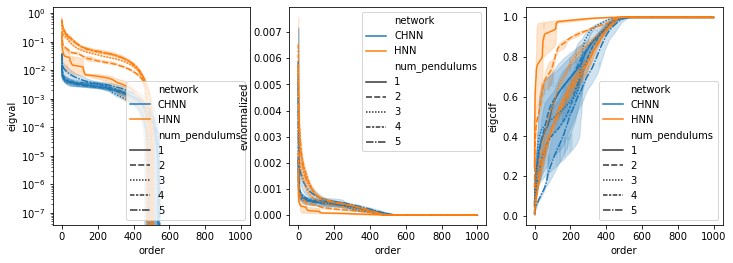

In [40]:
compare()

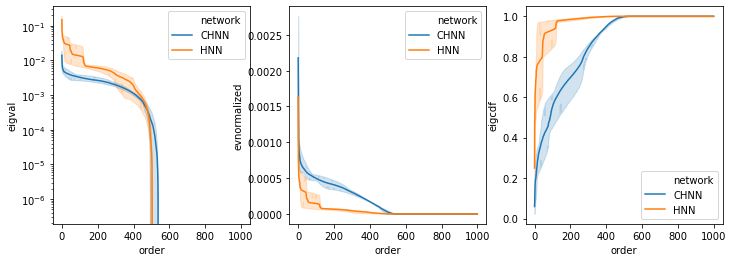

In [28]:
compare(1)

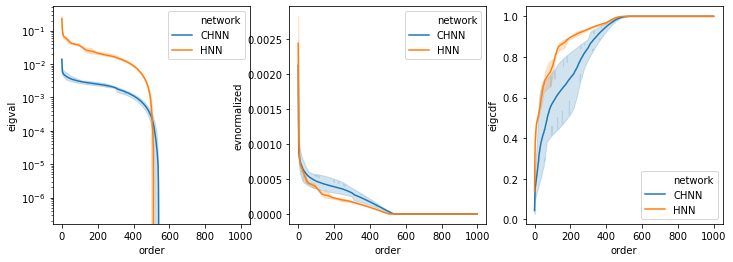

In [29]:
compare(2)

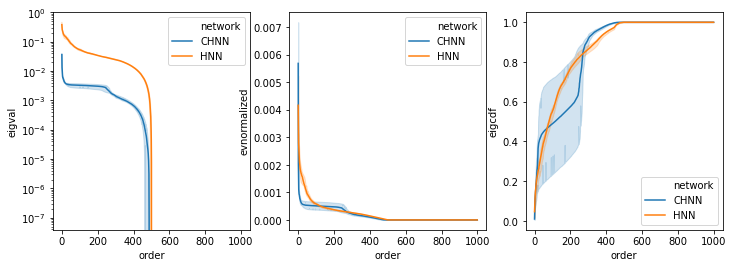

In [30]:
compare(3)

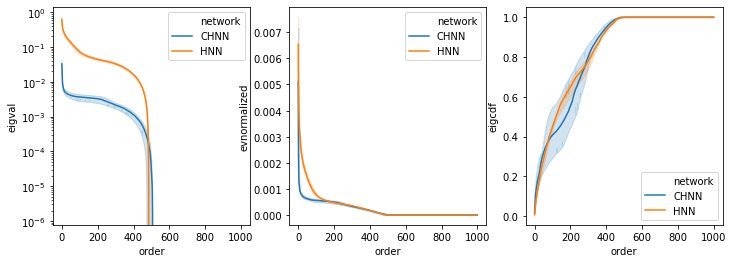

In [31]:
compare(4)

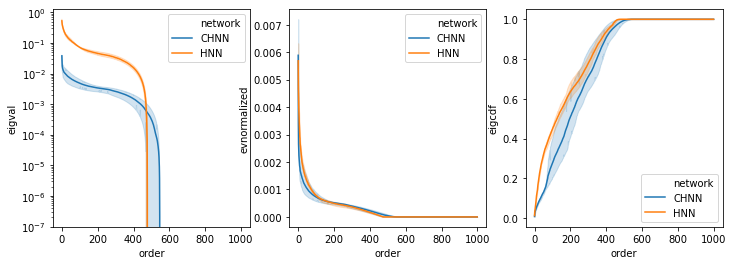

In [32]:
compare(5)

/home/alex/miniconda3/envs/ham37v2/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


[Text(0.5, 0, 'n where z=nthlargest')]

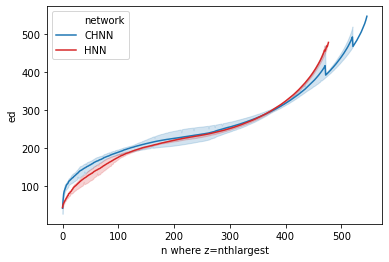

In [33]:
n = 5
eds = []
for i in range(1000):
    ed_chnn = df[df["network"] == "CHNN"].groupby(["num_pendulums", "network", "batch"])["eig_val"].apply(
                            lambda x: eff_dof(x, z=x.nlargest(1000).iloc[i], axis=-1)
    ).rename("ed")
    ed_hnn = df[df["network"] == "HNN"].groupby(["num_pendulums", "network", "batch"])["eig_val"].apply(
                            lambda x: eff_dof(x, z=x.nlargest(1000).iloc[i], axis=-1)
    ).rename("ed")
    ed = pd.concat([ed_chnn, ed_hnn]).reset_index()
    ed["nthlargest"] = i
    eds.append(ed)
    
eds = pd.concat(eds)

    
fig, axes = plt.subplots()
axes = [axes]

sns.lineplot(data=eds[eds["num_pendulums"] == n], x="nthlargest", y="ed", hue="network", ax=axes[0],
            palette=["C0", "C3"],
)
axes[0].set(xlabel="n where z=nthlargest")

In [16]:
df_eig_val = df.set_index(["num_pendulums", "network", "batch"])["eig_val"]

In [17]:
ed = df.groupby(["num_pendulums", "network", "batch"])["eig_val"].apply(
                        lambda x: eff_dof(x, z=800 * 1e-4, axis=-1)
                        ).rename("ed")

In [18]:
ed = ed.reset_index()

In [19]:
sns.set(font_scale=1.75)
sns.set_style('whitegrid')
colors = ["#00abdf", "#00058A", "#6A0078", (96/255,74/255,123/255), "#8E6100"]
sns.set_palette(sns.color_palette(colors))

from matplotlib import rc
rc('text', usetex=True)
rc('text.latex', preamble=[r'\usepackage{sansmath}', r'\sansmath']) #r'\usepackage{DejaVuSans}'
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans']})
rc('xtick.major', pad=12)
rc('ytick.major', pad=12)
rc('grid', linewidth=1.3)

INFO:matplotlib.texmanager:No LaTeX-compatible font found for the sans-serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the sans-serif font family in rcParams. Using default.


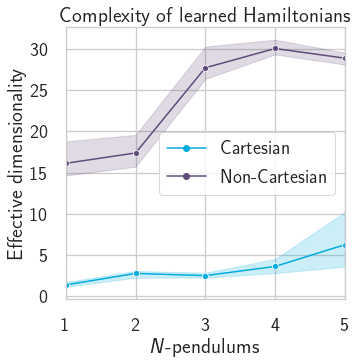

In [20]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.lineplot(data=ed.rename(columns={"num_pendulums": "n-pendulums"}), x="n-pendulums", y="ed", hue="network", ax=ax,
            palette=["C0", "C3"], markers=["o"]*ed["network"].nunique(),
            ci=95,
            dashes=False, style="network")
ax.set(xticks=[1,2,3,4,5], xlim=[1, 5],
       ylabel="Effective dimensionality",
       xlabel=r"$N$"+"-pendulums",
       title="Complexity of learned Hamiltonians")
handles, labels = ax.get_legend_handles_labels()
labels[1] = "Cartesian"
labels[2] = "Non-Cartesian"
ax.legend().remove()
ax.legend(handles=handles[1:], labels=labels[1:])

In [27]:
import matplotlib as mpl
#mpl.rcParams['figure.dpi'] = 1000
fig.savefig("eff_dim.pdf", bbox_inches="tight")

In [180]:
df["HNN-ed"] = eff_dof(df_hnn_evals, z=800 * 1e-4, axis=-1)
df["CHNN-ed"] = eff_dof(df_chnn_evals, z = 800 * 1e-4, axis=-1)

df["HNN-sr"] = stable_rank(df_hnn_evals, axis=-1)
df["CHNN-sr"] = stable_rank(df_chnn_evals, axis=-1)

df["HNN-sn"] = spectral_norm(df_hnn_evals, axis=-1)
df["CHNN-sn"] = spectral_norm(df_chnn_evals, axis=-1)

df["HNN-fn"] = frobenius_norm(df_hnn_evals, axis=-1)
df["CHNN-fn"] = frobenius_norm(df_chnn_evals, axis=-1)

[[], Text(0.5, 0, 'Top eigenvalues'), Text(0.5, 1.0, 'HNN')]

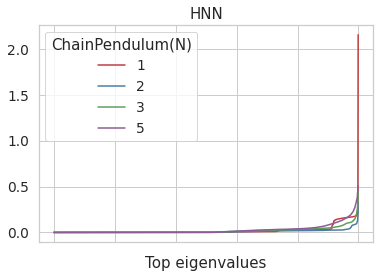

In [181]:
fig, ax = plt.subplots()
df_hnn_evals.T.plot(ax=ax)
ax.set(xlabel="Top eigenvalues", xticklabels=[], title="HNN")

[[], Text(0.5, 0, 'Top eigenvalues'), Text(0.5, 1.0, 'CHNN')]

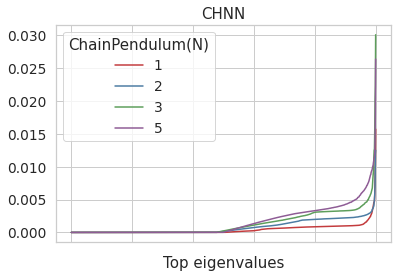

In [182]:
fig, ax = plt.subplots()
df_chnn_evals.T.plot(ax=ax)
ax.set(xlabel="Top eigenvalues", xticklabels=[], title="CHNN")

In [183]:
df.to_csv("complexities.csv")

In [184]:
df = pd.read_csv("complexities.csv")
df = df.set_index("N-Pendulum")

In [185]:
df

,HNN-2norm,CHNN-2norm,HNN-numparams,CHNN-numparams,HNN-ed,CHNN-ed,HNN-sr,CHNN-sr,HNN-sn,CHNN-sn,HNN-fn,CHNN-fn
N-Pendulum,,,,,,,,,,,,
1,36.348623,39.799898,265218,132610,120.99382,5.229253,10.253444,27.331242,2.152697,0.015708,4.698143,0.655220
2,39.331548,32.500244,267013,133123,86.49732,9.920650,30.163649,65.353280,0.324062,0.012496,3.126481,0.903678
3,44.142729,35.123342,269322,133636,137.01837,15.484471,43.260136,43.500683,0.441226,0.030069,4.368926,1.143679
5,53.196542,30.384151,275482,134662,160.95056,18.846247,55.524544,60.733350,0.504865,0.026358,5.294565,1.265223


In [186]:
df = df.T
df.index = pd.Index([(s.split("-")[0], s.split("-")[1]) for s in df.index]).set_names(["Network", "Series"])

In [187]:
df = df.reset_index()

In [188]:
df = df.melt(id_vars=["Network", "Series"], value_vars=[1, 2, 3, 5], var_name="N-Pendulums")

In [189]:
import seaborn as sns

sns.set(font_scale=1.25)
sns.set_style('whitegrid')
sns.set_palette(sns.color_palette("Set1", n_colors=6, desat=.67))

In [190]:
df[df["Series"] == "numparams"]

,Network,Series,N-Pendulums,value
2,HNN,numparams,1,265218.0
3,CHNN,numparams,1,132610.0
14,HNN,numparams,2,267013.0
15,CHNN,numparams,2,133123.0
26,HNN,numparams,3,269322.0
27,CHNN,numparams,3,133636.0
38,HNN,numparams,5,275482.0
39,CHNN,numparams,5,134662.0


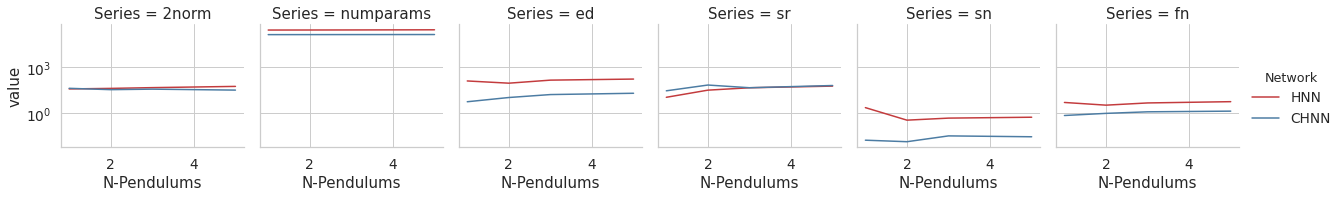

In [191]:
df_ = df

#fig, ax = plt.subplots()
g = sns.FacetGrid(df_, col="Series", hue="Network")
ax = g.map(sns.lineplot, "N-Pendulums", "value", markers=True)
g.add_legend()
ax.set(yscale="log")

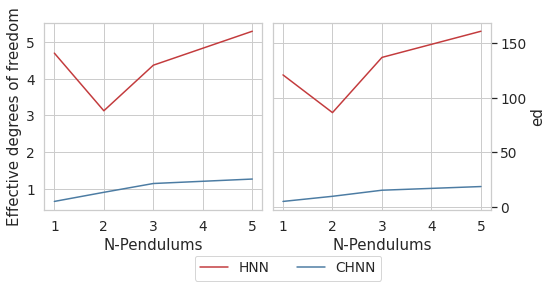

In [194]:
#metrics = ["2norm", "ed", "sr", "sn"]
metrics = ["fn", "ed"]

fig, axes = plt.subplots(ncols=len(metrics), figsize=(8, 4))
for ax, series in zip(axes.flatten(), metrics):
    df_ = df[df["Series"] == series]
    sns.lineplot(data=df_, ax=ax, y="value", x="N-Pendulums", hue="Network")
    ax.set(ylabel=series)
    ax.legend().remove()

axes[0].set(ylabel=r"Frobenius norm of Hessian")
axes[0].set(ylabel="Effective degrees of freedom")
axes[-1].yaxis.set_label_position("right")
axes[-1].yaxis.tick_right()

handles, labels = axes[-1].get_legend_handles_labels()
handles = handles[1:]
labels = labels[1:] # Get rid of legend title
fig.subplots_adjust(bottom=0.23, wspace=0.05, hspace=0.25)
fig.legend(handles=handles, labels=labels, bbox_to_anchor=(0., 0., 1.0, 0.1), loc="lower center", ncol=len(labels), borderaxespad=0.1)

[Text(0, 0.5, 'Effective dimensionality')]

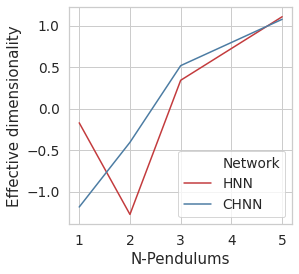

In [218]:
fig, ax = plt.subplots(figsize=(4, 4))
df_ = df[df["Series"] == "ed"].reset_index(drop=True)
df_["value_normalized"] = df_.groupby("Network")["value"].apply(lambda x: (x - x.mean())/x.std())

sns.lineplot(data=df_, ax=ax, y="value_normalized", x="N-Pendulums", hue="Network")
ax.set(ylabel=series)

#axes[0].set(ylabel=r"$L_2$" + " norm of parameters")
ax.set(ylabel=f"Effective dimensionality")

In [27]:
fig.savefig("complexity.pdf", bbox_inches="tight")